In [99]:
#Load the file with the dataset

import pandas as pd
import numpy as np

col = ['node_id1','node_id2','t']
df = pd.read_csv('datasets/primarySchool.dat', sep=' ', names= col)
#df = pd.read_csv('datasets/sex_dy_1.dat', sep=' ', names= col)
#df = pd.read_csv('datasets/BD_Fabiola_21Days_DyNetVis.dat', sep=' ', names= col)

#Create the network with Time

import networkx as nx

G = nx.MultiGraph()
G = nx.from_pandas_edgelist(df, 'node_id1', 'node_id2', edge_attr='t', create_using=nx.MultiGraph())

print(len(G.nodes()),len(G.edges()))

242 125773


In [100]:
#CALCULA AS COMUNIDADES LOUVAIN

from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

# compute the best partition
partition = community_louvain.best_partition(G.to_undirected(),randomize=None, random_state=1)
print('modularity value: ', community_louvain.modularity(partition, G.to_undirected()))

all_values = partition.values()
max_value = max(all_values)

#print(partition)

print('number of communities: ',max_value)

modularity value:  -0.15280336813846285
number of communities:  5


In [101]:
#CALCULA AS COMUNIDADES INFOMAP
from infomap import Infomap

# Command line flags can be added as a string to Infomap
#im = Infomap("--two-level --directed")

def getKeyByValue(mydict,value):
    return (list(mydict.keys())[list(mydict.values()).index(value)])

def calculateInfomap(G,seed):

    x = "--seed "+str(seed)

    #im = Infomap("--two-level --directed "+x)
    im = Infomap(" "+x)

    #CONVERTE OS NODES IDS PARA ADICIONAR NO INFOMAP
    nodes_to_id = {}

    id_new = 0
    for row in G.edges():
        
        if row[0] not in nodes_to_id:
            nodes_to_id[row[0]] = id_new
            id_new = id_new + 1
        if row[1] not in nodes_to_id:
            nodes_to_id[row[1]] = id_new
            id_new = id_new + 1
        # Add weight as optional third argument
        im.add_link(nodes_to_id[row[0]], nodes_to_id[row[1]])

    # Run the Infomap search algorithm to find optimal modules
    im.run()

    partition = {}
    for node in im.tree:
        if node.is_leaf:
            a = getKeyByValue(nodes_to_id, node.node_id)
            partition[a] = node.module_id
    
    return partition
    
partition = calculateInfomap(G,1)

all_values = partition.values()
max_value = max(all_values)

#print(partition)

print('number of communities: ',max_value)
#df_infomap_weightlog = pd.DataFrame(list(partition_weightlog.items()),columns = ['Country','Community']) 
#infomap_dictlog = df_infomap_weightlog.set_index('Country')['Community']

number of communities:  9


In [94]:
from collections import defaultdict

reversed_dict = defaultdict(list)
for key, value in partition.items():
    reversed_dict[value].append(key)

#for key in reversed_dict:
    #print(key, len(reversed_dict[key]))
    
#print(reversed_dict)

In [88]:
#LOUVAIN FOR TEMPORAL NETWORKS?

#https://louvain-igraph.readthedocs.io/en/latest/multiplex.html

#membership, improvement = louvain.find_partition_temporal(
 #                            [G_1, G_2, G_3],
  #                           louvain.CPMVertexPartition,
   #                          interslice_weight=0.1,
    #                         resolution_parameter=gamma)

In [102]:
#DIVIDE CADA RESULTADO DA COMUNIDADE EM UM GRAFO SEPARADO, REMOVENDO AS ARESTAS ENTRE COMUNIDADES

#Resultado algoritmo de detecção de comunidade = partition

dict_commun_graph = {}

G_2 = nx.Graph(G)

for row in G_2.edges(): #we use G_2 to have the unique list of edges to optimize the code
    if partition[row[0]] == partition[row[1]]:
        if partition[row[0]] not in dict_commun_graph:
            dict_commun_graph[partition[row[0]]] = []

        edge_list = G.get_edge_data(row[0], row[1])
        
        #print(edge_list,'\r\n')
        for edge_time in edge_list:
            dict_commun_graph[partition[row[0]]].append([row[0],row[1],edge_list[edge_time]['t']])
            
        

#INPUT: dict_commun_graph = dictionary of list of temporal edges resulting from the community partition
        #number_timeslices (optional) = number of how many timeslices the windows will be divided, default value = 5
#OUTPUT: new dicionary with edges list divided by timeslices
def divide_timeslices(dict_commun_graph, number_timeslices=5):
    min_t = min(df['t'])
    max_t = max(df['t'])

    total_t = max_t - min_t
    
    value_timeslice = round(total_t/number_timeslices)

    #print(round(total_t/number_timeslices))

    #Divide the communities into X number of times slices:

    
    dict_timeslice_graph = {}

    key_timeslice = 0
    for key in sorted(dict_commun_graph):
        #print('\r\ncommunity ',key)
        i = 0
        while i < number_timeslices: 
            #print()
            dict_timeslice_graph[key_timeslice] = []
            if i == 0:
                max_t = value_timeslice
                min_t = min(df['t'])
            if i == (number_timeslices - 1):
                max_t = max(df['t']) + 1

            
            #print(min_t,max_t)

            #Values from the temporal window are from min_t to max_t
            com = dict_commun_graph[key]
            
            
            
            count_com = 0
            for c in com:
                if (c[2] >= min_t) & (c[2] < max_t):
                    dict_timeslice_graph[key_timeslice].append(c)
                    count_com = count_com + 1
                    #if count_com % 100 == 0:
                        #print(c)

            
            #print('timeslice ',i, ' de ',min_t,' ate ',max_t, ' com ',count_com,' edges')
                
                        
            min_t = max_t
            max_t = max_t + value_timeslice

            i = i + 1
            key_timeslice = key_timeslice + 1
    return dict_timeslice_graph

#print('AQUI ',len(dict_commun_graph))
   
dict_commun_graph = divide_timeslices(dict_commun_graph,5)
    
#print('AQUI 2 ',len(dict_commun_graph))
    
from pandas import DataFrame

graph_lists = []

col = ['node_id1','node_id2','t']
for key in dict_commun_graph:
    com = dict_commun_graph[key]
    temporary_df = DataFrame(com,columns=col)
    temporary_graph = nx.MultiGraph()
    temporary_graph = nx.from_pandas_edgelist(temporary_df, 'node_id1', 'node_id2', edge_attr='t', create_using=nx.MultiGraph())

    graph_lists.append(temporary_graph)

#print(graph_lists,len(graph_lists))


In [6]:
import networkx as nx

#Implementação do artigo 
#Module-based visualization of large-scale graph network data, 2017, Journal of Visualization

#Module Detection = 5 options
#tree-connection, concentration, circular, low-connectivity, and full-connectivity.

##Tree-connection:
#The tree-connection pattern indicates that the graph is extended from a node and that some children of the root still contain the children.

#https://networkx.org/documentation/stable/reference/algorithms/tree.html?highlight=tree

#print('is tree: ',nx.is_tree(G))

#print('is forest: ',nx.is_forest(G))

#print(nx.is_arborescence(G)) #only for directed networks

#print(nx.is_branching(G)) #only for directed networks

#Concentration:
#The concentration pattern indicates that all children nodes are connected to the root and that each child does not have other connections.

#print('is tree: ',nx.is_tree(G))

#Circular:
#The circular pattern indicates that each node in the graph only has two links. 

#print(nx.find_cycle(G))
#print(len(nx.find_cycle(G)))

def has_cycle(G):
    if len(nx.find_cycle(G)) > 0:
        return True
    else:
        return False
        

def is_circular(G):
    n = len(G.nodes())
    c = len(nx.find_cycle(G))
    if (c > 0) & (c == n):
        return True
    else:
        return False
        
        
#print('has cycles: ',has_cycle(G))

#Example of circular graph
#G = nx.Graph()
#G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1)])

#print('is circular: ',is_circular(G))


#Full-connectivity:
#The full-connectivity pattern is a complete graph. 

def is_complete(G):
    n = len(G.nodes())
    e = len(G.edges())
    
    #n(n-1)/2, where n = number of nodes
    formula = n * (n-1)/2
    
    if e == formula:
        return True;
    else:
        return False;
    
#Example of complete graph
#G = nx.complete_graph(100)

#print('is complete: ',is_complete(G))

#Low-connectivity:
#The remaining structure of the graph will be classified as a low-connectivity pattern.

def is_low_connectivity(G):
    if ~is_complete_graph(G) & ~is_circular(G) & ~nx.is_tree(G) & ~nx.is_forest(G):
        return True
    else:
        return False
    
#print('is low connectivity: ',is_low_connectivity(G))


def is_star(G):
    if nx.is_tree(G):
        a = [x for x in G.nodes() if G.degree(x)==1]
        if len(a) == (len(G.nodes())-1):
            return True
        else:
            return False
    else:
        return False


def graph_topology(G):
    G_2 = nx.Graph(G) #transform multigraph (G) into graph (G_2) to calculate the topology
    if len(G_2.nodes()) == 0:
        return 'no_connectivity'
    elif is_star(G_2):
        return 'star'
    elif nx.is_tree(G_2):
        return 'tree'
    elif nx.is_forest(G_2):
        return 'forest'
    elif is_circular(G_2):
        return 'circular'
    elif is_complete(G_2):
        return 'complete'
    else:
        return 'low_connectivity'
    
    
#Temporal taxonomy
#Activity Frequency - Sporadic or Continuous
#To distinguish these scenarios, the time interval of the network ( T Final −T Initial ) is divided into sub-intervals of length S_I .
#If at least one of these intervals has no edges, the community has sporadic activity.

#If all intervals have at least one edge each, the community is classified as having continuous activity.

#S_I= Global average considering the time interval between two consecutive connections in each community

import statistics
import math

def get_timestamps(G):
    edges=sorted(G.edges(data='t'), key=lambda t: t[2])
    timestamp_list = []
    for e in edges:
        timestamp_list.append(e[2])
        
    return timestamp_list
      
#t_m is an optional parameter to divide timestamps
def time_frequency(G,t_m=-1):
    if len(G.nodes()) == 0:
        return 'no_temporal_connection'
    t_list = get_timestamps(G)
    if t_m == -1:
        t_m = round(statistics.mean(t_list))
        if t_m == 0:
            t_m = 1
        #print('t_m:',t_m)
    div = math.ceil((max(t_list) - min(t_list)) / t_m)    
    min_t = min(t_list)
    max_t = t_m
    x = 0
    while x < div:
        a = [i for i in t_list if (i >= min_t) & (i < max_t) ]
        #print(a)
        if len(a) == 0:
            return 'sporadic'
        min_t = max_t
        max_t = max_t + t_m
        x = x+1
    return 'continuous'




#Activity Dispersion - Dispersed or Grouped
#Suggestion: Activity Dispersion - Burst or Dispersed (?) Peak or Valley (?)
#A community has grouped activity if the majority of consecutive edges is too close to each other (according to a threshold T_dg ),
#or has dispersed activity otherwise.
#T_dg = The most frequent median time interval between two consecutive connections (mode of the medians)

from statistics import mean
from statistics import mode
from statistics import median
from scipy import stats as s


def find_max_mode(list1):
    list_table = statistics._counts(list1)
    len_table = len(list_table)

    if len_table == 1:
        max_mode = statistics.mode(list1)
    else:
        new_list = []
        for i in range(len_table):
            new_list.append(list_table[i][0])
        max_mode = max(new_list) # use the max value here
    return max_mode

#Tem que existir muitas arestas juntas consecutivamente

def calculate_dispersion(G):
    if len(G.nodes()) == 0:
        return 'no_temporal_dispersion'
    t_list = get_timestamps(G)
    i = -1
    time_interval = []
    for t in t_list:
        if i == -1:
            i = t
        else:
            time_interval.append(t-i)
            i=t
            
    #print(time_interval)
    
    if len(time_interval) == 0:
        tdg = 0
    else:
        tdg = round(find_max_mode(time_interval))
    t_h = 0.3
    #print('mode',tdg)
    
    consecutive_interval_value = math.ceil(len(t_list) * t_h) #quantidade de instantes de tempo consecutivos que tem que ter pouco intervalo

    #print('consecutive_interval_value',consecutive_interval_value)
    
    count=0
    for i in time_interval:
        if count == consecutive_interval_value:
            return 'grouped'
        if i <= tdg:
            count = count+1
        else:
            count = 0
    
    return 'dispersed'
    
    
    #a = [i for i in time_interval if i < tdg ]
    #if (len(a) / len(time_interval)) < t_h:
        #return 'grouped'
    #else:
        #return 'dispersed'

In [7]:
#G = nx.Graph()
#G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1)])

#G = nx.complete_graph(100)

#Pattern detection via k-clustering

#By following the pattern design, we can denote

#https://latex.codecogs.com/eqneditor/editor.php
#\alpha = \frac{\max(e_i)}{\sum e_i}, 
#\beta = \frac{count(e_i=2)}{n}, 
#\delta = \frac{1}{n}count(e_i > \frac{n}{2}), 
#where e_i denotes the neighbor count of node i and n denotes the node count of the module. 

import statistics

def graph_feature_vector(G):
    if len(G.nodes()) == 0:
        return [0.0,0.0,0.0]
    G_2 = nx.Graph(G) #transform multigraph (G) into graph (G_2) to calculate the feature
    x = []
    y = []
    z = []
    for i in G_2.nodes():

        e = list(G_2.neighbors(i))

        e_i = len(list(G_2.neighbors(i)))
        n = len(G_2.nodes())


        #from sympy import *
        #x = symbols('x')

        alpha = round(max(e)/sum(e),2)

        #print('alpha',round(alpha,2))

        count = 0
        for ee in e:
            #print(len(list(G.neighbors(ee))), (n/2))
            if len(list(G_2.neighbors(ee))) == 2:
                count = count + 1

        beta = count / n

        #print('beta',beta)

        count = 0
        for ee in e:
            if len(list(G_2.neighbors(ee))) > (n/2):
                count = count + 1

        delta = (1/n) * count 

        a=[alpha,beta,delta]
        x.append(a[0])
        y.append(a[1])
        z.append(a[2])

    mean_x = round(statistics.mean(x),2)
    mean_y = round(statistics.mean(y),2)
    mean_z = round(statistics.mean(z),2)

    return [mean_x,mean_y,mean_z]

In [114]:
#K-Means Clustering
#https://realpython.com/k-means-clustering-python/

import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

#circular [0.71, 0.5, 0.0]
#complete [0.02, 0.0, 0.99]
#star [0.88, 0.0, 0.16]
#tree [0.81, 0.24, 0.0]
#forest [0.8, 0.12, 0.0]
#low_connectivity [0.11, 0.0, 0.0]


def kmeans_implemented(features, n_clust):

    scaler = StandardScaler()
    #scaled_features = scaler.fit_transform(features)
    scaled_features = np.array(features)

    #scaled_features[:5]
    
    #0 = circular, 1 = complete, 2 = star, 3 = tree, 4 = forest, 5 = low_connectivity
    data = [[0.71, 0.5, 0.0],[0.02, 0.0, 0.99],[0.88, 0.0, 0.16],[0.81, 0.24, 0.0],[0.8, 0.12, 0.0],[0.11, 0.0, 0.0]]
    centroids  = np.array(data)
    
    #print('centroids: ', centroids)
    
    #https://stackoverflow.com/questions/60205100/define-cluster-centers-manually
    kmeans = KMeans(
        init=centroids,
        n_clusters=n_clust,
        max_iter=1,
    )
    

    kmeans.fit(scaled_features)

    print('inertia: ',kmeans.inertia_)
    kmeans_silhouette = silhouette_score(scaled_features, kmeans.labels_).round(2)


    # Plot the data and cluster silhouette comparison
    #fig, (ax1) = plt.subplots(1, figsize=(8, 6), sharex=True, sharey=True)
    #fig.suptitle(f"Clustering Algorithm Comparison: Crescents", fontsize=16)
    fte_colors = {
        0: "#0000ff", #blue
        1: "#ff0000", #red
        2: "#ff00ff", #purple
        3: "#000000", #black
        4: "#FFA500", #orange
        5: "#00ff00", #green
    }
    # The k-means plot
    km_colors = [fte_colors[label] for label in kmeans.labels_]
    
    #print(scaled_features[:, 0], scaled_features[:, 1], scaled_features[:, 2])
    
    #ax1.scatter(scaled_features[:, 0], scaled_features[:, 1], c=km_colors)
    #ax1.set_title(f"k-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 12})

    
    fig=plt.figure()
    ax=Axes3D(fig)
    ax.scatter(scaled_features[:, 0], scaled_features[:, 1],scaled_features[:, 2], c=km_colors)
    ax.set_xlabel(r'$\alpha$', fontsize=20)
    ax.set_ylabel(r'$\beta$', fontsize=20)
    ax.set_zlabel(r'$\delta$', fontsize=20)
    
    #ax.view_init(60, 35)
    
    plt.show()
    
    
    return kmeans.labels_


no_connectivity:  9  
star:  0 
tree:  0 
forest:  0 
circular:  0 
complete:  0 
low_connectivity:  36 

no_temporal_connection:  9 
sporadic:  0 
continuos:  0 
no_temporal_dispersion:  9 
grouped:  0 
dispersed:  36 
total:  45


inertia:  0.3404422414554056


C:\Anaconda\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


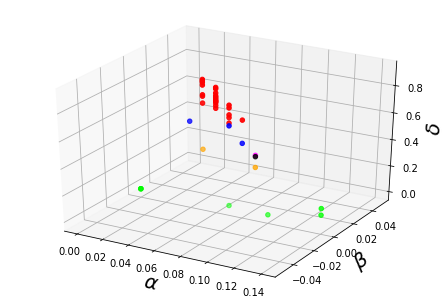

Counter({1: 25, 5: 13, 0: 3, 4: 2, 2: 1, 3: 1})


In [115]:
count = 0

count_nocon = 0
count_star = 0
count_tree = 0
count_forest = 0
count_circular = 0
count_complete = 0
count_low = 0

count_no_t_con = 0
count_spor = 0
count_cont = 0

count_no_t_disp = 0
count_group = 0
count_dis = 0

features = []

for G in graph_lists:
    G2 = nx.Graph(G)
    x = graph_topology(G)
    y = graph_feature_vector(G)
    z = time_frequency(G)
    w = calculate_dispersion(G)
    
    features.append(y)
    
    #print(len(G.nodes()),len(G.edges()),len(G2.edges()),x,y,z,w)
    #if count % 5 == 0:
        #print()
    
    if x == 'no_connectivity':
        count_nocon = count_nocon + 1
    if x == 'star':
        count_star = count_star + 1
    if x == 'tree':
        count_tree = count_tree + 1
    if x == 'forest':
        count_forest = count_forest + 1
    if x == 'circular':
        count_circular = count_circular + 1
    if x == 'complete':
        count_complete = count_complete + 1
    if x == 'low_connectivity':
        count_low = count_low + 1
    
    if z == 'no_temporal_connection':
        count_no_t_con = count_no_t_con + 1
    if z == 'sporadic':
        count_spor = count_spor + 1
    if z == 'continuos':
        count_cont = count_cont + 1
    
    if w == 'no_temporal_dispersion':
        count_no_t_disp = count_no_t_disp + 1
    if w == 'grouped':
        count_group = count_group + 1
    if w == 'dispersed':
        count_dis = count_dis + 1
        
    count = count + 1
    
print('no_connectivity: ',count_nocon,' \r\nstar: ',count_star,'\r\ntree: ',count_tree, '\r\nforest: ',count_forest, '\r\ncircular: ',count_circular, '\r\ncomplete: ',count_complete, 
      '\r\nlow_connectivity: ',count_low, '\r\n\r\nno_temporal_connection: ', count_no_t_con, '\r\nsporadic: ',count_spor,'\r\ncontinuos: ',count_cont, '\r\nno_temporal_dispersion: ',count_no_t_disp,
      '\r\ngrouped: ', count_group, '\r\ndispersed: ',count_dis, '\r\ntotal: ',count)

print()
print()

a = kmeans_implemented(features,6)

import collections
print(collections.Counter(sorted(a)))


# The dbscan plot
#db_colors = [fte_colors[label] for label in dbscan.labels_]
#ax2.scatter(scaled_features[:, 0], scaled_features[:, 1], c=db_colors)
#ax2.set_title(
 #   f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12}
#)
#plt.show()

In [ ]:

from sklearn.cluster import DBSCAN

kmeans = KMeans(n_clusters=6)
dbscan = DBSCAN(eps=0.3)


scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


# Fit the algorithms to the features
kmeans.fit(scaled_features)
dbscan.fit(scaled_features)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
    scaled_features, kmeans.labels_
).round(2)
dbscan_silhouette = silhouette_score(
    scaled_features, dbscan.labels_
).round (2)

print(kmeans_silhouette)
print(dbscan_silhouette)


In [ ]:
#0 = circular (blue), 1 = complete (red), 
#2 = star (purple), 3 = tree (black), 
#4 = forest (orange), 5 = low_connectivity (green)

     #  0: "#0000ff", #blue
    #    1: "#ff0000", #red
   #     2: "#ff00ff", #purple
  #      3: "#000000", #black
 #       4: "#FFA500", #orange
#        5: "#00ff00", #green


#circular [0.71, 0.5, 0.0]
#complete [0.02, 0.0, 0.99]
#star [0.88, 0.0, 0.16]
#tree [0.81, 0.24, 0.0]
#forest [0.8, 0.12, 0.0]
#low_connectivity [0.11, 0.0, 0.0]

In [41]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix

# 5 datapoints with 3 features
data = [[1, 0, 0],
        [1, 0.2, 0],
        [0, 0, 1],
        [0, 0, 0.9],
        [1, 0, 0.1]]

X = np.array(data)

distance_matrix(X,X)

centroid_idx = [0,2] # let data point 0 and 2 be our centroids
centroids = X[centroid_idx,:]
print(centroids) # [[1. 0. 0.]
                 # [0. 0. 1.]]

kmeans = KMeans(n_clusters=2, init=centroids, max_iter=1) # just run one k-Means iteration so that the centroids are not updated

kmeans.fit(X)
kmeans.labels_


[[1. 0. 0.]
 [0. 0. 1.]]


C:\Anaconda\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


array([0, 0, 1, 1, 0])